<a href="https://colab.research.google.com/github/busyboxs/Some-resources-useful-for-me/blob/master/pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train pytorch example on colab

## Install pytorch on colab

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x55cfe5b16000 @  0x7f24612402a4 0x55cf8d319f18 0x55cf8d40da85 0x55cf8d32d4ca 0x55cf8d332232 0x55cf8d32ad0a 0x55cf8d3325fe 0x55cf8d32ad0a 0x55cf8d3325fe 0x55cf8d32ad0a 0x55cf8d3325fe 0x55cf8d32ad0a 0x55cf8d332c38 0x55cf8d32ad0a 0x55cf8d3325fe 0x55cf8d32ad0a 0x55cf8d3325fe 0x55cf8d332232 0x55cf8d332232 0x55cf8d32ad0a 0x55cf8d332c38 0x55cf8d332232 0x55cf8d32ad0a 0x55cf8d332c38 0x55cf8d32ad0a 0x55cf8d332c38 0x55cf8d32ad0a 0x55cf8d3325fe 0x55cf8d32ad0a 0x55cf8d32a629 0x55cf8d35b61f


## Change Pillow to 4.0.0

安装完pytorch之后**一定要执行下面Pillow的安装**，不然后面在显示图像时会遇到`AttributeError: module ‘PIL.Image’ has no attribute ‘register_extensions`错误

In [0]:
!pip install Pillow==4.0.0

    100% |████████████████████████████████| 5.6MB 5.3MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2018-12-06 01:59:30--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.151.21, 54.192.151.109, 54.192.151.98, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.151.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  8.95MB/s    in 6.5s    

2018-12-06 01:59:38 (6.97 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [0]:
!ls

sample_data


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp -r hymenoptera_data /content/gdrive/My\ Drive/Dataset/hymenoptera_data

In [0]:
!mkdir /content/gdrive/My\ Drive/Dataset

In [0]:
!rm -rf hymenoptera_data

In [0]:
!unzip -q hymenoptera_data.zip

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/My Drive/Dataset/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
print(device)

cuda:0


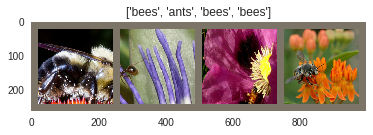

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, padding=20)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 41954050.95it/s]


In [0]:
num_ftrs = model_ft.fc.in_features

In [0]:
model_ft.fc = nn.Linear(num_ftrs, 2)

In [0]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7337 Acc: 0.7336
val Loss: 0.4130 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.5447 Acc: 0.7951
val Loss: 0.2691 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4038 Acc: 0.8279
val Loss: 0.3304 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.5222 Acc: 0.7992
val Loss: 0.3269 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5003 Acc: 0.7869
val Loss: 0.2728 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4960 Acc: 0.8115
val Loss: 0.3753 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.4323 Acc: 0.8115
val Loss: 0.2942 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4104 Acc: 0.8402
val Loss: 0.2772 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3104 Acc: 0.8484
val Loss: 0.2589 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3187 Acc: 0.8607
val Loss: 0.2828 Acc: 0.8758

Epoch 10/24
----------
train Loss: 0.2812 Acc: 0.9057
val Loss: 0.2580 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2537 Acc: 0.8730
val Loss: 0.2225 Acc: 0.9216

Ep

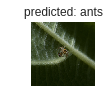

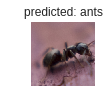

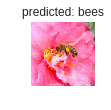

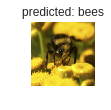

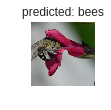

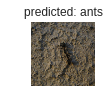

In [0]:
visualize_model(model_ft)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5612 Acc: 0.6967
val Loss: 0.2264 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5907 Acc: 0.7131
val Loss: 0.1933 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4371 Acc: 0.8238
val Loss: 0.1705 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4926 Acc: 0.7992
val Loss: 0.1954 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4479 Acc: 0.7951
val Loss: 0.2992 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.3640 Acc: 0.8361
val Loss: 0.2026 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4419 Acc: 0.8238
val Loss: 0.1808 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3852 Acc: 0.8320
val Loss: 0.1860 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2519 Acc: 0.8934
val Loss: 0.1751 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3427 Acc: 0.8566
val Loss: 0.1765 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3514 Acc: 0.8689
val Loss: 0.1703 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4649 Acc: 0.7910
val Loss: 0.1807 Acc: 0.9346

Ep

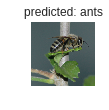

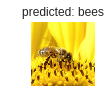

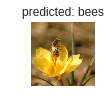

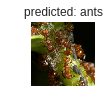

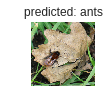

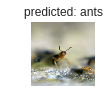

In [0]:
visualize_model(model_conv)